<h1>Final Project for Text Information Systems (CS410 Fall 2022)</h1>
Video Game Review Classifier by Nate Smolczyk (nds6)

In [165]:
import sklearn as sk
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import joblib

First, we need to load in the data into a Pandas dataframe. I've cleaned up the original datasource to only have the data that is relevant to me, which is the review text and rating.

In [166]:
df = pd.read_json('./videogames.json')
df = shuffle(df)

As we can see, the rating categories are not evenly distributed. In this dataset, the reviews were overwhelmingly 5 stars

<BarContainer object of 5 artists>

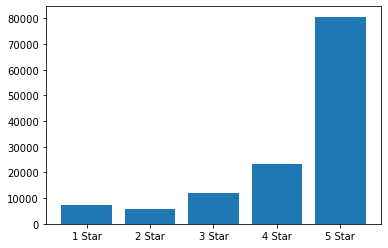

In [167]:
onestarratings = df[df['rating'] == 1]
twostarratings = df[df['rating'] == 2]
threestarratings = df[df['rating'] == 3]
fourstarratings = df[df['rating'] == 4]
fivestarratings = df[df['rating'] == 5]

yAxis = [onestarratings.rating.size, twostarratings.rating.size, threestarratings.rating.size, fourstarratings.rating.size, fivestarratings.rating.size]
xAxis = ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star']

plt.bar(xAxis, yAxis)


To mitigate this issue, I created a subset of data with an equal number of reviews from each category:

In [168]:
subsetdata_no3starReviews = pd.DataFrame()
subsetdata_no3starReviews = subsetdata_no3starReviews.append(onestarratings[0:5800])
subsetdata_no3starReviews = subsetdata_no3starReviews.append(twostarratings[0:5800])
subsetdata_no3starReviews = subsetdata_no3starReviews.append(fourstarratings[0:5800])
subsetdata_no3starReviews = subsetdata_no3starReviews.append(fivestarratings[0:5800])
subsetdata_with3starReviews = subsetdata_no3starReviews.append(threestarratings[0:5800])
subsetdata_no3starReviews = shuffle(subsetdata_no3starReviews)
subsetdata_with3starReviews = shuffle(subsetdata_with3starReviews)

In [169]:
# I found that I was unable to achieve suitable accuracy classifying the 5 different categories. 
# I simplified the problem by lumping the reviews into three categories: Positive, Negative, and Neutral
def ThreeCategories(rating):
    if(rating == 1 or rating == 2):
        return "negative"
    if(rating == 3):
        return "neutral"
    if(rating == 4 or rating == 5):
        return "positive"
    return ""

def TwoCategories_3StarsPositive(rating):
    if(rating == 1 or rating == 2):
        return "negative"
    if(rating == 3 or rating == 4 or rating == 5):
        return "positive"
    return ""

def TwoCategories_3StarsNegative(rating):
    if(rating == 1 or rating == 2 or rating == 3):
        return "negative"
    if(rating == 4 or rating == 5):
        return "positive"
    return ""

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

# This function cleans up the document for better processing
def cleanDocument(document):
    tokens = word_tokenize(document)
    tokens = [t for t in tokens if t.isalpha() ] # removes symbols
    tokens = [t.lower() for t in tokens ] # converts all words to lowercase
    tokens = [t for t in tokens if not t in stop_words] # removes stop words
    tokens = [t for t in tokens if len(t) > 2 and len(t) < 30] # removes words shorter than 2 characters or longer than 30 characters
    tokens = [ps.stem(t) for t in tokens ] # stems each word
    return " ".join(tokens)

subsetdata_no3starReviews.text = subsetdata_no3starReviews.text.apply(cleanDocument)
#subsetdata_no3starReviews.rating = subsetdata_no3starReviews.rating.apply(TwoCategories_3StarsPositive)

In [163]:
# Create the testing and training data split
X = subsetdata_no3starReviews.text
y = subsetdata_no3starReviews.rating

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [164]:
# After trying a few different classification models, I found that Stochastic Gradient Descent gave the highest accuracy

sgdClassifier = SGDClassifier(loss='epsilon_insensitive', penalty='l2',alpha=1e-3, max_iter=1000, tol=None)

classifier = sgdClassifier

# In this pipeline, the features are unigrams and bigrams, and each word is transformed using IDF weighting
pipeline = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))), ('tfidf', TfidfTransformer()), ('clf', classifier)])
pipeline.fit(X_train, y_train)
joblib.dump(pipeline, 'model.joblib') # export the model for use by the server 

y_pred = pipeline.predict(X_test)

print('Overall Accuracy: ' + str(accuracy_score(y_pred, y_test)))
print(classification_report(y_test, y_pred))


Overall Accuracy: 0.7910344827586206
              precision    recall  f1-score   support

    negative       0.72      0.95      0.82      2882
    positive       0.93      0.64      0.75      2918

    accuracy                           0.79      5800
   macro avg       0.82      0.79      0.79      5800
weighted avg       0.82      0.79      0.79      5800

